In [1]:
from constraints import *
from helper import *

# Dubins' Car

Dubins' car (discretized) dynamics for control input $u_t \in [-1,1]$:

$x_{t+1} = V cos(\theta_t)\Delta_t + x_t$         
$y_{t+1} = V sin(\theta_t)\Delta_t + y_t$     
$\theta_{t+1} = u_t\Delta_t + \theta_t$

### Forward Euler

In [2]:
def forwardEulerDC(init,constants,plot=False):
    x0, y0, theta0 = init[0], init[1], init[2]
    
    T = constants["T"]
    del_t = constants["del_t"]
    V = constants["V"]
    xs, ys, thetas = [x0], [y0], [theta0]
    x,y,theta = x0, y0, theta0
    for t in range(T):
        u_t = np.random.uniform(-0.1,0.1)
        x, y, theta = V*np.cos(theta)*del_t + x, V*np.sin(theta)*del_t + y, u_t*del_t + theta
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        
    traj = [(xs[i],ys[i],thetas[i]) for i in range(len(xs))]
    return traj

def forwardEulerDC_control(init,constants,plot=False):
    x0, y0, theta0 = init[0], init[1], init[2]
    
    T = constants["T"]
    del_t = constants["del_t"]
    V = constants["V"]
    xs, ys, thetas,us = [], [], [], []
    x,y,theta = x0, y0, theta0
    for t in range(T):
        u_t = np.random.uniform(-1,1)
        us.append(u_t)
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        x, y, theta = V*np.cos(theta)*del_t + x, V*np.sin(theta)*del_t + y, u_t*del_t + theta
        
    traj = [(xs[i],ys[i],thetas[i],us[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [3]:
# horizon and forward Euler time step
T = 10
del_t = 0.1

# box constraints for initial state
x0 = 1
y0 = 1
theta0 = 1
x_dev = 0.01
y_dev = 0.01
theta_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0
theta_up_b = theta_dev + theta0
theta_lw_b = -1*theta_dev + theta0

V = 1

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0, "theta0":theta0, "V":V}

x_range, y_range, theta_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev], [theta0 - theta_dev, theta0 + theta_dev]

### Fast Reachable Set Computation

In [4]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
theta0_bounds = BoxConstraints(theta_lw_b,theta_up_b)
u0_bounds = BoxConstraints(-0.1,0.1)

var_bounds = {"x":x0_bounds, "y":y0_bounds, "theta":theta0_bounds, "u":u0_bounds}

x_0_coeffs = {"x":1, "y":0, "theta":0, "u":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "theta":0, "u":0, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

theta_0_coeffs = {"x":0, "y":0, "theta":1, "u":0, "_const":0}
theta_0 = LinearConstraints(Line(theta_0_coeffs.copy()), Line(theta_0_coeffs.copy()),var_bounds)

u_0_coeffs = {"x":0, "y":0, "theta":0, "u":1, "_const":0}
u_0 = LinearConstraints(Line(u_0_coeffs.copy()), Line(u_0_coeffs.copy()),var_bounds)

for t in range(constants["T"]):
    tt = time.time()
    V = constants["V"]
    box_x, box_y, box_theta = x_0.eval_box(), y_0.eval_box(), theta_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    boxes_fast.append(([box_x.lower,box_x.upper],[box_y.lower,box_y.upper],[box_theta.lower,box_theta.upper]))
    
    x_temp = theta_0.cos(adaptive=True).mult_const(constants["del_t"]*V).add(x_0)
    y_temp = theta_0.sin(adaptive=True).mult_const(constants["del_t"]*V).add(y_0)
    theta_temp = u_0.mult_const(constants["del_t"]).add(theta_0)
    x_0, y_0, theta_0 = x_temp, y_temp, theta_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

### CVX Reachable Set Computation

In [5]:
def DubinsConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}):
    times = []
    ss = []
    boxes = []
    del_t = constants["del_t"]
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        theta = variables[t]["theta"]
        theta_bounds = bounds(theta,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        thetaL,thetaU = theta_bounds
        boxes.append(([xL,xU],[yL,yU],[thetaL,thetaU]))
        ss.append((xU-xL)*(yU-yL)*(thetaU-thetaL))
        
        # del_t*u
        u = variables[t]["u"]
        constraints.append(u <= control_bounds[0][1]*del_t)
        constraints.append(u >= control_bounds[0][0]*del_t)
        
        # cos
        c1 = variables[t]["c1"]
        constraints.extend(cos_adaptive_cvx(c1,theta,theta_bounds))
        
        # V*del_t*cosine
        c = variables[t]["c"]
        constraints.append(c == constants["V"]*del_t*c1)
        
        # sin
        s1 = variables[t]["s1"]
        constraints.extend(sin_adaptive_cvx(s1,theta,theta_bounds))
        
        # V*del_t*sine
        s = variables[t]["s"]
        constraints.append(s == constants["V"]*del_t*s1)
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == c + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == s + y)
        
        theta_new = variables[t+1]["theta"]
        constraints.append(theta_new == u + theta)

        tt = time.time() - tt
        times.append(tt)
    
    return variables,constraints, times, ss, boxes

In [6]:
variables = [{"u":cvxpy.Variable(),"c1":cvxpy.Variable(),"s1":cvxpy.Variable(),"c":cvxpy.Variable(),"s":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"theta":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]
theta = variables[0]["theta"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)
constraints.append(theta >= theta_lw_b)
constraints.append(theta <= theta_up_b)

control_bounds = [(-0.1,0.1) for t in range(T)]

variables,constraints,times_convex,areas_convex,boxes_convex = DubinsConstraints(T,variables,constraints,control_bounds,use_convex=False,constants=constants)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)
thetaL,thetaU = bounds(variables[-1]["theta"],constraints)

Academic license - for non-commercial use only


### Visualizations

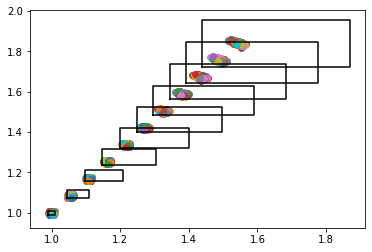

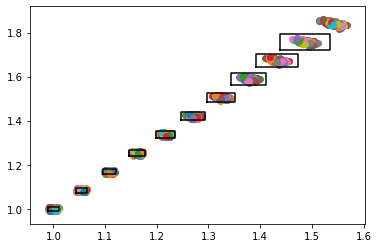

In [7]:
trajs = random_trajs([x_range,y_range,theta_range],forwardEulerDC,constants,n=100)
plot_2d_boxes_traj(boxes_fast, trajs)
plot_2d_boxes_traj(boxes_convex, trajs)

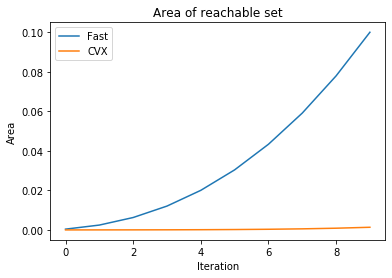

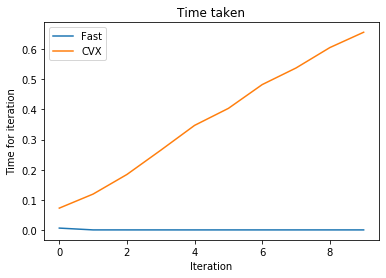

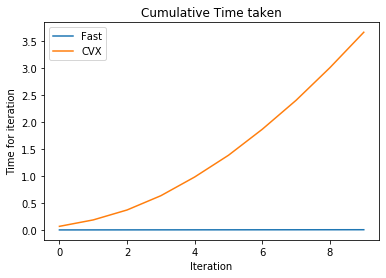

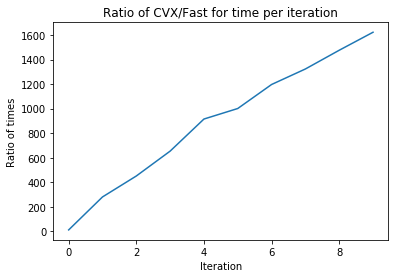

In [8]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

NOTE: Forward euler assumes constant control at $u_t \equiv 1$. Should change in the future.

True
True


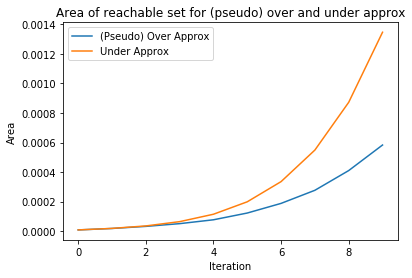

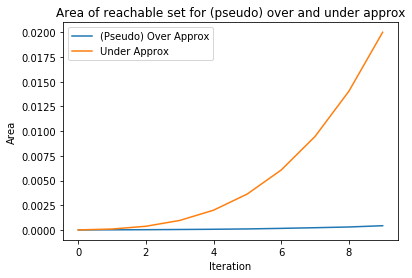

In [9]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range,theta_range],n=num_samples,forwardEuler=forwardEulerDC,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range,theta_range],n=num_samples,forwardEuler=forwardEulerDC,constants=constants))

### Bounding box using outer approximation

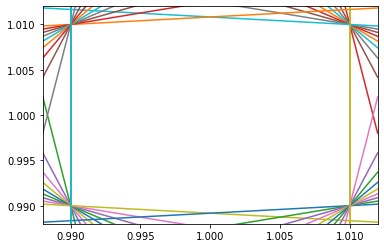

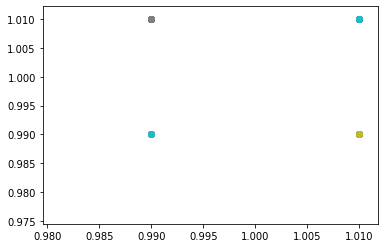

In [11]:
variables = {"x":x_0,"y":y_0,"theta":theta_0}
A, b, proj_dim = linear_to_polytope(var_bounds, variables, order=["x", "y", "theta"])
plot_outer_approximation(20,A,b,100)